In [1]:
# Setup functions for the demo
import numpy as np
import glob
import os
import importlib
import yaml
import warnings
import albumentations
import glob
import json
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.utils.data import random_split, DataLoader, Dataset
from skimage.transform import rescale, resize, downscale_local_mean
from omegaconf import OmegaConf
from skimage.io import imread, imsave
from PIL import Image
from omegaconf import OmegaConf
from tqdm.notebook import tqdm
from core.modules.util import box_mask, BatchRandomMask
from core.modules.losses.lpips import LPIPS
warnings.filterwarnings("ignore", category=UserWarning) 

def imshow(images, titles=None, save_path=None):
    n_img = len(images)
    plt.rcParams['figure.figsize'] = [4*n_img, 4*n_img]
    
    if n_img > 1:
        fig, ax = plt.subplots(1, n_img)
        for i in range(n_img):
            if titles is not None and i < len(titles):
                ax[i].set_title(titles[i])
            ax[i].axis('off')
            ax[i].imshow(images[i])
    else:
        if titles is not None:
            plt.set_titile(titles[0])
        plt.axis('off')
        plt.imshow(images[0])

    if save_path is not None:
        plt.savefig(save_path)

def center_crop(image, s=512):
    h, w = image.shape[:2]
    if s > h or s > w:
        image = rescale(image, s/min(h,w), anti_aliasing=True)
        image = (image * 255).astype(np.uint8)
        h, w = image.shape[:2]
    ih = (h - s) // 2   
    iw = (w - s) // 2
    return image[ih:ih+s, iw:iw+s]
    
# load a single input
def preprocess(x, res=256, normalize=True):
    if normalize:
        x = x.transpose(2,0,1)
        x = (torch.from_numpy(x).float().to(device) / 127.5 - 1).unsqueeze(0)
    else:
        x = torch.from_numpy(x).float().to(device).unsqueeze(0)
    return torch.nn.functional.interpolate(x, size=(res,res))
    
def to_img(x):
    x = (x.permute(0, 2, 3, 1) * 127.5 + 127.5).round().clamp(0, 255).to(torch.uint8)
    return x[0].detach().cpu().numpy()

def readmask(path):
    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0
    return mask

def read_image(path):
    image = center_crop(imread(path))
    image = preprocess(image, res=target_res)
    return image[:,:3]

def get_data(k, res, p=None):
    if p is None:
        p = places_val_files[k]                 
    gt = center_crop(imread(p))
    if len(gt.shape) == 2:
        gt = np.repeat(gt[...,None], 3, axis=2) 
    gt = preprocess(gt, res)
    try:
        mask_in = preprocess(readmask(os.path.join(maskfolder, f"{ids[k]}.png"))[None], res,normalize=False)
    except Exception:
        return gt, None
    return gt, mask_in

def instantiate_from_config(config):
    if not "target" in config:
        raise KeyError("Expected key `target` to instantiate.")
    return get_obj_from_str(config["target"])(**config.get("params", dict()))


def get_obj_from_str(string, reload=False):
    module, cls = string.rsplit(".", 1)
    if reload:
        module_imp = importlib.import_module(module)
        importlib.reload(module_imp)
    return getattr(importlib.import_module(module, package=None), cls)


/home/chenh/anaconda3/envs/vanilla/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# Configurations
target_model = "places" # model: places | celeba
target_res = 256 # image resolution: 256x256/512x512 for Places365, 256x256 for CelebA
gpu_idx = input("specify the gpu index for loading the model (e.g. 0): ") # gpu index for loading the model

# Model Parameters
CLAMP_RATIO = 0.25 # clamp ratio for the restrictive encoder
SAMPLING_RATIO = 0.2 # sampling ratio for iterative token predictions
TEMPERATURE = 1.0 # temperature scaling before logits softmax
TEMPERATURE_ANNEALING = 0.9 # annealing factor applied to the temperature in each iteration
DETERMINISTIC = False # whether we want the model to generate deterministic results

specify the gpu index for loading the model (e.g. 0):  0


In [ ]:
# Loading the model
device = torch.device(f'cuda:{gpu_idx}')
current_dir = os.path.abspath('.')
if target_model == "places":
    if target_res == 512:
        config_path = "configs/places_inpainting_512.yaml"
    else:
        config_path = "configs/places_inpainting.yaml"
else:
    assert target_model == 'celeba'
    target_res = 256
    config_path = "configs/celeba_inpainting.yaml"

config = OmegaConf.load(config_path)
config['data']['params']['batch_size'] = 1
model = instantiate_from_config(config.model).to(device)

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Restored from ckpts/places256_vqgan1024_BASE.ckpt
Restored from ckpts/places256_partialencoder.ckpt
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Initializing with a pretrained U-Net model
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from core/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
Restored from ckpts/places_unet_512.ckpt


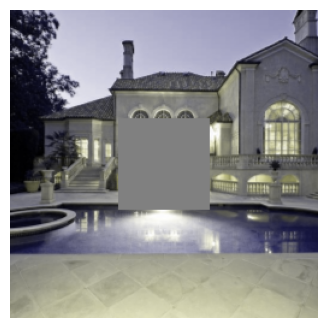

In [4]:
# Load an example input (at the moment we only have some examples from Places365-Standard)

# Images
input_image_list = glob.glob("example_data/*.png")
idx = 0 
x = read_image(input_image_list[idx]).to(device)
if x.shape[-1] != 256:
    x_down = torch.nn.functional.interpolate(x, (256, 256))
else:
    x_down = x

# Mask
mask = box_mask(x_down.shape, device, 0.3, det=True).float() # box mask
# mask = torch.from_numpy(BatchRandomMask(x_down.shape[0], x_down.shape[-1], hole_range=[0.0,1.0])).to(device) # free-form mask
if target_res != mask.shape[-1]:
    mask_up = torch.nn.functional.interpolate(mask, (target_res, target_res))
else:
    mask_up = mask

imshow([to_img(x*mask_up)])

Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


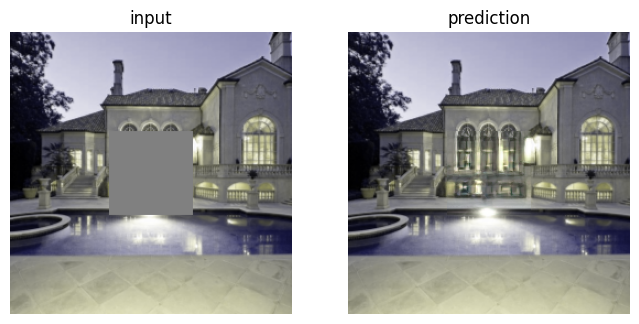

In [5]:
# Inference code

'''
candidate settings : 
1) 0.33 ratio, 0.8 degrad, 1.0t, no topk (more error prone)
2) 0.1 ratio, 0.95 degrad. 1.0t, no topk
3) 0.2 ratio, 0.9 degrad, 1.0t, no topk (default)
'''
def forward_to_indices(model, batch, z_indices, mask):
    x, c = model.get_xc(batch)
    x = x.to(device=device).float()
    c = c.to(device=device).float()
    quant_c, c_indices = model.encode_to_c(c)
    mask = model.preprocess_mask(mask, z_indices)
    r_indices = torch.full_like(z_indices, model.mask_token)
    z_start_indices = mask*z_indices+(1-mask)*r_indices      
    index_sample, probs, candidates = model.sample(z_start_indices.to(device=device), 
                               c_indices.to(device=device),
                               sampling_ratio=SAMPLING_RATIO,
                               temperature=TEMPERATURE,
                               sample=not DETERMINISTIC,
                               temperature_degradation=TEMPERATURE_ANNEALING,
                               top_k=None,
                               return_probs=True,
                               scheduler='cosine',
                              )
    return index_sample, probs, candidates

with torch.no_grad():
    mask = torch.round(mask)    
    VQModel, Encoder, Transformer, Unet = model.helper_model
    VQModel = VQModel.to(device)
    Encoder = Encoder.to(device)
    Transformer = Transformer.to(device)        
    quant_z, _, info, mask_out = Encoder.encode(x_down*mask, mask, clamp_ratio=CLAMP_RATIO)
    mask_out = mask_out.reshape(x.shape[0], -1)
    z_indices = info[2].reshape(x.shape[0], -1)
    
    # batch input is always 256x256
    new_batch = {'image': (x_down*mask).permute(0,2,3,1)}
    
    z_indices_complete, probs, candidates = forward_to_indices(Transformer, new_batch, z_indices, mask_out)
    B, C, H, W = quant_z.shape
    quant_z_complete = VQModel.quantize.get_codebook_entry(z_indices_complete.reshape(-1).int(), shape=(B, H, W, C))   
    dec, _, mout, f0, f1 = model.current_model(new_batch, 
                                quant=quant_z_complete, 
                                mask_in=mask, 
                                mask_out=mask_out.reshape(B, 1, H, W),
                                return_fstg=False, debug=True)  
    rec = x_down * mask + dec * (1-mask) 
    if Unet is not None:
        Unet = Unet.to(device)
        rec = Unet.refine(rec, None, recomp=False)
        rec = x * mask_up + rec * (1-mask_up)

imshow([to_img(x*mask_up),to_img(rec)], titles=['input', 'prediction'])
